# BEE 4750 Homework 4: Generating Capacity Expansion

**Name**: Lesedi Kgatla

**ID**: lk535

> **Due Date**
>
> Friday, 10/27/23, 9:00pm

## Overview

### Instructions

-   In Problem 1, you will formulate, solve, and analyze a standard
    generating capacity expansion problem.
-   In Problem 2, you will add a CO<sub>2</sub> constraint to the
    capacity expansion problem and identify changes in the resulting
    solution.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\lk535\Desktop\Classes\BEE 4750\Homeworks\hw04 - LesediK01\hw04-LesediK01`

   Installed XZ_jll ───────────── v5.4.3+1
   Installed CodecBzip2 ───────── v0.7.2


   Installed GR_jll ───────────── v0.72.9+0
   Installed MutableArithmetics ─ v1.3.0
   Installed Unitful ──────────── v1.15.0


   Installed DisplayAs ────────── v0.1.6
   Installed ArgCheck ─────────── v2.3.0
   Installed PooledArrays ─────── v1.4.2


   Installed DataStructures ───── v0.18.14


   Installed Compat ───────────── v4.8.0


   Installed HiGHS ────────────── v1.5.2


   Installed MarkdownTables ───── v1.1.0


   Installed ForwardDiff ──────── v0.10.35


   Installed StringManipulation ─ v0.3.0


   Installed JuMP ─────────────── v1.13.0


   Installed MathOptInterface ─── v1.18.0


   Installed ColorSchemes ─────── v3.22.0


Precompiling project...

  ✓ ArgCheck


  ✓ CommonSubexpressions
  ✓ Compat


  ✓ DisplayAs


  ✓ PooledArrays


  ✓ Tables


  ✓ SnoopPrecompile


  ✓ HiGHS_jll


  ✓ Xorg_libXau_jll


  ✓ XZ_jll


  ✓ Xorg_libXdmcp_jll


  ✓ StringManipulation


  ✓ Xorg_xtrans_jll
  ✓ Xorg_libpthread_stubs_jll


  ✓ CodecBzip2
  ✓ 

InlineStrings


  ✓ FreeType2_jll


  ✓ ColorVectorSpace → SpecialFunctionsExt


  ✓ BenchmarkTools


  ✓ Compat → CompatLinearAlgebraExt


  ✓ MutableArithmetics


  ✓ Libtiff_jll
  ✓ MarkdownTables


  ✓ FilePathsBase


  ✓ Xorg_libxcb_jll
  ✓ HTTP


  ✓ Fontconfig_jll
  ✓ WeakRefStrings


  ✓ ForwardDiff


  ✓ Xorg_libX11_jll


  ✓ Xorg_xcb_util_jll


  ✓ DataStructures


  ✓ Xorg_libXrender_jll


  ✓ Xorg_libXext_jll


  ✓ Xorg_libXfixes_jll


  ✓ Xorg_libxkbfile_jll


  ✓ Xorg_xcb_util_image_jll


  ✓ Xorg_xcb_util_keysyms_jll


  ✓ SortingAlgorithms


  ✓ Xorg_xcb_util_renderutil_jll
  ✓ Xorg_xcb_util_wm_jll


  ✓ Libglvnd_jll


  ✓ Xorg_libXinerama_jll


  ✓ ColorSchemes


  ✓ Xorg_libXrandr_jll


  ✓ Cairo_jll


  ✓ Xorg_libXcursor_jll


  ✓ Xorg_libXi_jll


  ✓ Xorg_xkbcomp_jll


  ✓ HarfBuzz_jll


  ✓ StatsBase


  ✓ GLFW_jll


  ✓ Xorg_xkeyboard_config_jll


  ✓ PrettyTables


  ✓ libass_jll


  ✓ xkbcommon_jll


  ✓ FFMPEG_jll


  ✓ Qt6Base_jll


  ✓ FFMPEG


  ✓ GR_jll


  ✓ GR


  ✓ CSV


  ✓ PlotUtils


  ✓ PlotThemes


  ✓ Unitful
  ✓ RecipesPipeline


  ✓ UnitfulLatexify


  ✓ DataFrames


  ✓ Latexify → DataFramesExt


  ✓ MathOptInterface


  ✓ HiGHS


  ✓ JuMP


  ✓ Plots


  ✓ Plots → UnitfulExt
  74 dependencies successfully precompiled in 122 seconds. 99 already precompiled.


In [1]:
using JuMP
using HiGHS
using DataFrames
using Plots
using Measures
using CSV
using MarkdownTables

## Problems (Total: 100 Points)

For this problem, we will use hourly load (demand) data from 2013 in New
York’s Zone C (which includes Ithaca). The load data is loaded and
plotted below in <a href="#fig-demand" class="quarto-xref">Figure 1</a>.

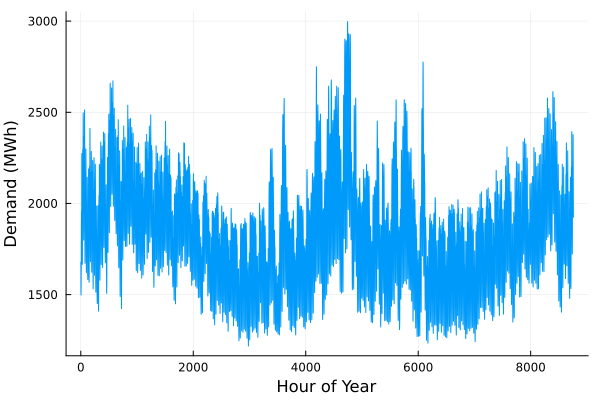

In [2]:
# load the data, pull Zone C, and reformat the DataFrame
NY_demand = DataFrame(CSV.File("data/2013_hourly_load_NY.csv"))
rename!(NY_demand, :"Time Stamp" => :Date)
demand = NY_demand[:, [:Date, :C]]
rename!(demand, :C => :Demand)
demand[:, :Hour] = 1:nrow(demand)

# plot demand
plot(demand.Hour, demand.Demand, xlabel="Hour of Year", ylabel="Demand (MWh)", label=:false)

Next, we load the generator data. This data includes fixed costs (\$/MW
installed), variable costs (\$/MWh generated), and CO<sub>2</sub>
emissions intensity (tCO<sub>2</sub>/MWh generated).

In [3]:
gens = DataFrame(CSV.File("data/generators.csv"))

Row,Plant,FixedCost,VarCost,Emissions
,String15,Int64,Int64,Float64
1,Geothermal,450000,0,0.0
2,Coal,220000,24,1.0
3,NG CCGT,82000,30,0.43
4,NG CT,65000,40,0.55
5,Wind,91000,0,0.0
6,Solar,70000,0,0.0


Finally, we load the hourly solar and wind capacity factors, which are
plotted in <a href="#fig-cf" class="quarto-xref">Figure 2</a>. These
tell us the fraction of installed capacity which is expected to be
available in a given hour for generation (typically based on the average
meteorology).

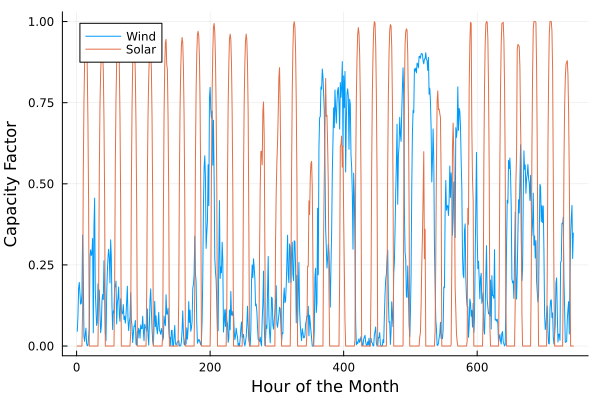

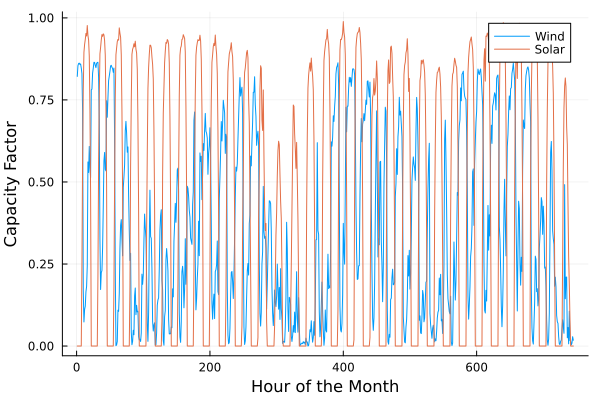

In [4]:
# load capacify factors into a DataFrame
cap_factor = DataFrame(CSV.File("data/wind_solar_capacity_factors.csv"))

# plot January capacity factors
p1 = plot(cap_factor.Wind[1:(24*31)], label="Wind")
plot!(cap_factor.Solar[1:(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

p2 = plot(cap_factor.Wind[4344:4344+(24*31)], label="Wind")
plot!(cap_factor.Solar[4344:4344+(24*31)], label="Solar")
xaxis!("Hour of the Month")
yaxis!("Capacity Factor")

display(p1)
display(p2)

You have been asked to develop a generating capacity expansion plan for
the utility in Riley, NY, which currently has no existing electrical
generation infrastructure. The utility can build any of the following
plant types: geothermal, coal, natural gas combined cycle gas turbine
(CCGT), natural gas combustion turbine (CT), solar, and wind.

While coal, CCGT, and CT plants can generate at their full installed
capacity, geothermal plants operate at maximum 85% capacity, and solar
and wind available capacities vary by the hour depend on the expected
meteorology. The utility will also penalize any non-served demand at a
rate of \$1000/MWh.

> **Significant Digits**
>
> Use `round(x; digits=n)` to report values to the appropriate
> precision!

> **Getting Variable Output Values**
>
> `value.(x)` will report the values of a `JuMP` variable `x`, but it
> will return a special container which holds other information about
> `x` that is useful for `JuMP`. This means that you can’t use this
> output directly for further calculations. To just extract the values,
> use `value.(x).data`.

> **Suppressing Model Command Output**
>
> The output of specifying model components (variable or constraints)
> can be quite large for this problem because of the number of time
> periods. If you end a cell with an `@variable` or `@constraint`
> command, I *highly* recommend suppressing output by adding a
> semi-colon after the last command, or you might find that your
> notebook crashes.

### Problem 1 (22 points)

Your first task is to find a capacity expansion plan which minimizes
total costs of investment and operation.

#### Problem 1.1 (2 points)

Identify and define the decision variables for the problem. Make sure to
include units.

The decision variables are:

$C_i$ and $G_i,_t$ 

$C_i$ is the capacity of the plant, with units (MW). The plant type is represented by i, where i is either Geothermal, Coal, CCGT, CT, Solar, or Wind plant type. 

$G_i,_t$ is the generation (MWh) from plant type i at time t, measured in hours. 

#### Problem 1.2 (3 points)

Formulate the objective function. Make sure to include any needed
derivations or justifications for your equation(s) and define any
additional required notation beyond that introduced in Problem 1.1.

The objective is to minimize the total costs; therefore, 

Min Cost = $\Sigma_i (C_i$ x $FixedCost_i)$ + $\Sigma_{i,t} (G_{i,t}$ x $VarCost_i)$ + ($\Sigma_t (Demand_t - \Sigma_i G_i,_t)^+$ x 1000) 

($\Sigma_t (Demand_t - \Sigma_i G_i,_t)^+$ * 1000) accounts for the penalty rate when demand (positive deviations) is not met.   


#### Problem 1.3 (4 points)

Derive all relevant constraints. Make sure to include any needed
justifications or derivations.

The capacity of the plants cannot be exceeded; therefore we have a capacity constraint. 

For Coal, CCGT, CT:    $G_i,_t \le C_i * Availability_i(t)$    ,

For the Geothermal plant type: $G_i,_t \le 0.85 * C_i$

For Solar plant types: $G_i,_t \le C_i * capacityfactor_{solar,t}$

For Wind plant types: $G_i,_t \le C_i * capacityfactor_{wind,t}$

Total generation from the plant type must at least meet the demand. Therefore, we have a demand constraint.
$\Sigma G_i,_t \ge Demand_t$ 

Capacity and Generation cannot be 0. Therefore, we also have non-negative constraints

$C_i \ge 0$

$G_i,_t \ge 0$

#### Problem 1.4 (3 points)

Implement your optimization problem in `JuMP`.

In [5]:
#Define model
m = Model(HiGHS.Optimizer)

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: HiGHS

In [6]:
#Define variables based on data from the dataframe
FixedCost = gens.FixedCost
VarCost = gens.VarCost  

#Define decision variables
@variable(m, C[1:6] >= 0) #capacity for each type of plant
@variable(m, G[1:6, 1:nrow(demand)] >= 0) #generation for each type at each hour
@variable(m, non_served[1:nrow(demand)] >= 0) #non-served energy at each hour

#Define the objective function
@objective(m, Min, sum(FixedCost[i]*C[i] for i=1:6) + 
    sum(VarCost[i]*G[i,t] for i=1:6, t=1:nrow(demand)) +  1000 * 
    sum(non_served[t] for t=1:nrow(demand)))

#Define the constraints
for t=1:nrow(demand)
    #Compute the constraint that Demand should equal total generation + non_served 
    @constraint(m, sum(G[:,t]) + non_served[t] == demand.Demand[t])
    
    for i=1:6
        if i == 2 || i == 3 || i == 4 #plant-wise constraint for the Coal, CCGT, CT
            @constraint(m, G[i,t] <= C[i])
        elseif i == 1 #Geothermal
            @constraint(m, G[i,t] <= 0.85*C[i])
        elseif i == 5 #Solar
            @constraint(m, G[i,t] <= cap_factor.Solar[t]*C[i])
        elseif i == 6 #Wind
            @constraint(m, G[i,t] <= cap_factor.Wind[t]*C[i])
        end
    end
end

In [7]:
optimize!(m)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
56856 rows, 56862 cols, 153048 nonzeros
56856 rows, 56862 cols, 153048 nonzeros
Presolve : Reductions: rows 56856(-4464); columns 56862(-4464); elements 153048(-8928)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(4.52383e+06) 0s
      41652     6.4142472560e+08 Pr: 0(0); Du: 0(7.48202e-11) 2s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 41652
Objective value     :  6.4142472560e+08
HiGHS run time      :          2.49


#### Problem 1.5 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What will the total cost be? How much energy
will be non-served?

In [11]:
#Compute utility build capacity for each plant type
optimal_capacity = value.(C)

println("The optimal capacity for each plant type (MW) is as follows:")
for (idx, plant) in enumerate(gens.Plant)
    println("$(plant): ", round(optimal_capacity[idx], digits=2), " MW")
end

#Compute total cost
total_cost = objective_value(m)
println("\nTotal Cost: \$", round(total_cost, digits=2))

#Compute non-served energy
total_non_served_energy = sum(value.(non_served))
println("\nTotal Non-served Energy: ", round(total_non_served_energy, digits=2), " MWh")


The optimal capacity for each plant type (MW) is as follows:
Geothermal: 0.0 MW
Coal: 0.0 MW
NG CCGT: 1512.02 MW
NG CT: 750.9 MW
Wind: 724.51 MW
Solar: 2023.82 MW

Total Cost: $6.414247256e8



Total Non-served Energy: 6735.53 MWh


From the optimization model, no investment should be made for the geothermal and coal plants. Utility build for each generating plant is ordered in order of capacity as follows:
The largest recommended investment is in a solar plant type with a copacity of ~ 2024MW. Following that, Natural Gas Combined Cycle Gas Turbine (NG CCGT) plant with a capacity
of ~ 1512 MW should be built. A wind energy plant of ~ 725 should be built. Thus, investment should be made towards builidng solar, natural gas, and wind plants. However, since
there is a total non-served energy of ~ 6736 MWh, consideration may have to be given towards investing more in NG CT, since it is a peaking plant.  


#### Problem 1.6 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 1.5? Do these results make sense given the generator data?

In [20]:
#Compute total annual generation
annual_generation = sum(value.(G), dims=2) #compute annual generation for each plant type
total_annual_generation = sum(annual_generation) #total annual generation

#Compute the fraction of annual generation for each plant
generation_fraction = annual_generation ./ total_annual_generation 

#Compute the fraction of built capacity for each plant
total_built_capacity = sum(optimal_capacity)
capacity_fraction = optimal_capacity ./ total_built_capacity

println("Fraction of Annual Generation vs. Fraction of Built Capacity:")
for (idx, plant) in enumerate(gens.Plant)
    println("$(plant): ")
    println("    Generation: ", round(generation_fraction[idx], digits=2) * 100 ,
        "% of annual generation")
    println("    Capacity:   ", round(capacity_fraction[idx], digits=2) * 100, 
        "% of the total built capacity")
end

Fraction of Annual Generation vs. Fraction of Built Capacity:
Geothermal: 
    Generation: 0.0% of annual generation
    Capacity:   0.0% of the total built capacity
Coal: 
    Generation: 0.0% of annual generation
    Capacity:   0.0% of the total built capacity
NG CCGT: 
    Generation: 48.0% of annual generation
    Capacity:   30.0% of the total built capacity
NG CT: 
    Generation: 3.0% of annual generation
    Capacity:   15.0% of the total built capacity
Wind: 
    Generation: 13.0% of annual generation
    Capacity:   14.000000000000002% of the total built capacity
Solar: 
    Generation: 36.0% of annual generation
    Capacity:   40.0% of the total built capacity


From Problem 1.5, the results from the optimization model suggested that no investments be made into geothermal and coal power plants. In the order of max investment 
(based on total built capacity):  the investments were solar, NG CCGT, NG CT, and Wind. This coincides with the results from Problem 1.5. For with the exception of the 
wind and solar plant types, which have built capacities that ~match their respective generation, from how the contribution of NG CCGT and NG CT to annual generation 
relative to their built capacity, one can make the assumption that this variability in use (scheduling for each plant) may be attributed to factors such as  
making provision for non-served energy.   

### Problem 2 (18 points)

The NY state legislature is considering enacting an annual
CO<sub>2</sub> limit, which for the utility would limit the emissions in
its footprint to 1.5 MtCO<sub>2</sub>/yr.

#### Problem 2.1 (3 points)

What changes are needed to your linear program from Problem 1?
Re-formulate the problem and report it in standard form.

A $CO_2$ constraint has to be set. However, because $CO_2$ is related to energy generation, it must therefore be expressed as follows:

$\Sigma_{i,t}^n$  ($G_{i,t}$  x  $Emissionsfactor_i) \le  1.5$ x $10^6$

From Problem 1.1 $G_i,t$ was defined as the generation (MWh) from plant type i at time t, 
and Emissionsfactor_i is the emission factor for plant type i

$$\begin{equation}
\begin{aligned}
& \min & \Sigma_i (C_i x FixedCost_i) + \Sigma_{i,t} (G_{i,t} x VarCost_i) + (\Sigma_t (Demand_t - \Sigma_i G_{i,t})^+ x 1000)\\
&\text{subject to} & \\
& & \Sigma_{i,t}^n  (G_{i,t}  x  Emissionsfactor_i) \le  1.5 x 10^6\\
& & G_{i,t} \leq 0.85 * C_i\\
& & G_{i,t} \leq C_i * capfactor_{solar,t}\\
& & G_{i,t} \leq C_i * capfactor_{wind,t}\\
& & \Sigma G_{i,t} \geq Demand_t\\ 
& & C_i \geq 0\\
& & G_{1,t} \geq 0
\end{aligned}
\end{equation} $$

#### Problem 2.2 (3 points)

Implement the new optimization problem in `JuMP`.

In [5]:
#I used the same code as the code used to solve Problem 1-4, with the inclusion of the emissions constraint.

#define model
m = Model(HiGHS.Optimizer)

#Define variables based on data from the dataframe
FixedCost = gens.FixedCost
VarCost = gens.VarCost  

#Define decision variables
@variable(m, C[1:6] >= 0) #capacity for each type of plant
@variable(m, G[1:6, 1:nrow(demand)] >= 0) #generation for each type at each hour
@variable(m, non_served[1:nrow(demand)] >= 0) #non-served energy at each hour

#Define the objective function
@objective(m, Min, sum(FixedCost[i]*C[i] for i=1:6) + 
    sum(VarCost[i]*G[i,t] for i=1:6, t=1:nrow(demand)) + 
    1000 * sum(non_served[t] for t=1:nrow(demand)))

#Define the constraints
for t=1:nrow(demand)
    #Compute the constraint that Demand should equal total generation + non_served    
    @constraint(m, sum(G[:,t]) + non_served[t] == demand.Demand[t])  
    for i=1:6
        if i == 2 || i == 3 || i == 4 #plant-wise constraint for the Coal, CCGT, CT
            @constraint(m, G[i,t] <= C[i])
        elseif i == 1 #Geothermal
            @constraint(m, G[i,t] <= 0.85*C[i])
        elseif i == 5 #Solar
            @constraint(m, G[i,t] <= cap_factor.Solar[t]*C[i])
        elseif i == 6 #Wind
            @constraint(m, G[i,t] <= cap_factor.Wind[t]*C[i])
        end
    end
end

@constraint(m, CO_2_constraint, sum(gens.Emissions[i] * sum(G[i,:]) for i=1:6) <= 1.5e6)

CO_2_constraint : G[2,1] + 0.43 G[3,1] + 0.55 G[4,1] + G[2,2] + 0.43 G[3,2] + 0.55 G[4,2] + G[2,3] + 0.43 G[3,3] + 0.55 G[4,3] + G[2,4] + 0.43 G[3,4] + 0.55 G[4,4] + G[2,5] + 0.43 G[3,5] + 0.55 G[4,5] + G[2,6] + 0.43 G[3,6] + 0.55 G[4,6] + G[2,7] + 0.43 G[3,7] + 0.55 G[4,7] + G[2,8] + 0.43 G[3,8] + 0.55 G[4,8] + G[2,9] + 0.43 G[3,9] + 0.55 G[4,9] + G[2,10] + 0.43 G[3,10] + 0.55 G[4,10] + G[2,11] + 0.43 G[3,11] + 0.55 G[4,11] + G[2,12] + 0.43 G[3,12] + 0.55 G[4,12] + G[2,13] + 0.43 G[3,13] + 0.55 G[4,13] + G[2,14] + 0.43 G[3,14] + 0.55 G[4,14] + G[2,15] + 0.43 G[3,15] + 0.55 G[4,15] + G[2,16] + 0.43 G[3,16] + 0.55 G[4,16] + G[2,17] + 0.43 G[3,17] + 0.55 G[4,17] + G[2,18] + 0.43 G[3,18] + 0.55 G[4,18] + G[2,19] + 0.43 G[3,19] + 0.55 G[4,19] + G[2,20] + 0.43 G[3,20] + 0.55 G[4,20] + G[2,21] + 0.43 G[3,21] + 0.55 G[4,21] + G[2,22] + 0.43 G[3,22] + 0.55 G[4,22] + G[2,23] + 0.43 G[3,23] + 0.55 G[4,23] + G[2,24] + 0.43 G[3,24] + 0.55 G[4,24] + G[2,25] + 0.43 G[3,25] + 0.55 G[4,25] + G[2,26] +

In [6]:
optimize!(m)

Running HiGHS 1.5.3 [date: 1970-01-01, git hash: 45a127b78]
Copyright (c) 2023 HiGHS under MIT licence terms
Presolving model
56857 rows, 56862 cols, 179328 nonzeros
56857 rows, 56862 cols, 179328 nonzeros
Presolve : Reductions: rows 56857(-4464); columns 56862(-4464); elements 179328(-8928)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0     0.0000000000e+00 Pr: 8760(5.18855e+06) 0s
      24536     6.7550475080e+08 Pr: 11215(8.04748e+06); Du: 0(1.47885e-07) 5s
      27984     7.4575496150e+08 Pr: 10281(1.61019e+06); Du: 0(3.89153e-14) 10s
      31109     7.5385214855e+08 Pr: 0(0); Du: 0(6.76437e-11) 14s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 31109
Objective value     :  7.5385214855e+08
HiGHS run time      :         14.36


#### Problem 2.3 (5 points)

Find the optimal solution. How much should the utility build of each
type of generating plant? What is different from your plan from Problem
1? Do these changes make sense?

In [7]:
#I used the code used to solve Problem 1-5 to help answer the question, then compared the two outputs

#Compute utility build capacity for each plant type
optimal_capacity = value.(C)

println("The optimal capacity for each plant type (MW) is as follows:")
for (idx, plant) in enumerate(gens.Plant)
    println("$(plant): ", round(optimal_capacity[idx], digits=2), " MW")
end

#Compute total cost
total_cost = objective_value(m)
println("\nTotal Cost: \$", round(total_cost, digits=2))

#Compute non-served energy
total_non_served_energy = sum(value.(non_served))
println("\nTotal Non-served Energy: ", round(total_non_served_energy, digits=2), " MWh")

The optimal capacity for each plant type (MW) is as follows:
Geothermal: 71.14 MW
Coal: 0.0 MW
NG CCGT: 1641.17 MW
NG CT: 454.05 MW
Wind: 2075.01 MW
Solar: 3619.84 MW



Total Cost: $7.5385214855e8

Total Non-served Energy: 10694.09 MWh


The results show an increase in capacity for geothermal plant type. The reasoning behind this inclusion could be attributed to ensuring complaince to the $CO_2$ emission limit
because the $CO_2$ emitted from geothermal power plants is relatively low in comparison. The omission of coal plant makes sense due to the emissions of $CO_2$ from coal power
plants being one of the largest contributors to $CO_2$ emission in the sector. 
A slight increase in NG CCGT is noted; whilst a notable decrease in NG CT is seen. Both power plants are more efficient sources; however, NG CCGT plants have lower $CO_2$ emissions,
having a greater carbon to electity per unit fuel ratio. 
Significant increases in the capacity of solar and wind are seen, when compared to problem 1.5. This makes sense since renewable energy power plants have little to no $CO_2$ emissions. 

Thus, being mindful of the changes in capacity as a result of the emissions constraint, the increase in the total costs is to be expected. However, a trade off is noted from the increase
in total non-served energy that in implementing a 'greener' plan, the demand to supply ratio has been impacted.      

#### Problem 2.4 (5 points)

What fraction of annual generation does each plant type produce? How
does this compare to the breakdown of built capacity that you found in
Problem 2.3? What are the differences between these results and your
plan from Problem 1?

In [11]:
#I used the code used to solve Problem 1-6 to help answer the question, then compared the two outputs

#Compute total annual generation
annual_generation_1 = sum(value.(G), dims=2) #annual generation for each plant type
total_annual_generation_1 = sum(annual_generation_1) #total annual generation

#Compute the fraction of annual generation for each plant
generation_fraction_1 = annual_generation_1 ./ total_annual_generation_1 

#Compute the fraction of built capacity for each plant
total_built_capacity_1 = sum(optimal_capacity)
capacity_fraction_1 = optimal_capacity ./ total_built_capacity_1

println("Fraction of Annual Generation vs. Fraction of Built Capacity:")
for (idx, plant) in enumerate(gens.Plant)
    println("$(plant): ")
    println("    Generation: ", round(generation_fraction_1[idx], digits=2) * 100 , 
        "% of annual generation")
    println("    Capacity:   ", round(capacity_fraction_1[idx], digits=2) * 100, 
        "% of the total built capacity")
end

Fraction of Annual Generation vs. Fraction of Built Capacity:
Geothermal: 
    Generation: 1.0% of annual generation
    Capacity:   1.0% of the total built capacity
Coal: 
    Generation: 0.0% of annual generation
    Capacity:   0.0% of the total built capacity
NG CCGT: 
    Generation: 20.0% of annual generation
    Capacity:   21.0% of the total built capacity
NG CT: 
    Generation: 1.0% of annual generation
    Capacity:   6.0% of the total built capacity
Wind: 
    Generation: 30.0% of annual generation
    Capacity:   26.0% of the total built capacity
Solar: 
    Generation: 47.0% of annual generation
    Capacity:   46.0% of the total built capacity


The geothermal plant type now has a built capacity of 1%, which is equally maximised. The fraction of annual generation for NG CCGT has changed from 48% to 20%. 
In tandem, capacity has changed from 30% to now 21%. NG CT has dropped from 3% to 1%, whilst built capacity has significantly changed from 15% to 6%. Fraction 
of annual generation for both wind and solar plant types have increased, from 13% to 30% and 36% to 47% respectively. Similarly, solar counts for the highest
annual generation fraction. Built capacity for wind and solar plant types has also increased, from 14% to 26% and 40% to 46% respectively. 

Here a shift towards renewable energy sources is noted, from the increase in the annual generation of wind and solar plant types. The decrease in the annual 
generation and built capacity for both NG CCGT and NG CT shows a reduced reliance on gas turbines. Given the emissions constraint applied in the optimization, 
the changes observed seem to make sense.   

#### Problem 2.5 (2 points)

What would the value to the utility be of allowing it to emit an
additional 1000 tCO<sub>2</sub>/yr? An additional 5000?

In [12]:
#Compute shadow price of the emissions constraint
shadow_price(CO_2_constraint) #shadow price per tCO₂

#Compute value for additional emissions
Value1000_tCO2 = shadow_price(CO_2_constraint) * 1000
Value5000_tCO2 = shadow_price(CO_2_constraint) * 5000

println("Value emitting an additional 1000 tCO₂/yr: \$", 
    round(value_1000_tCO2, digits=2))
println("Value of emitting an additional 5000 tCO₂/yr: \$", 
    round(value_5000_tCO2, digits=2))


Value emitting an additional 1000 tCO₂/yr: $-200502.99
Value of emitting an additional 5000 tCO₂/yr: $-1.00251495e6


## References

List any external references consulted, including classmates.

Boudreau, E. Getting Familiar With Loops In Julia: An introduction to using loops in tandem with conditionals in the Julia programming language. 2020. [Online] https://towardsdatascience.com/getting-familiar-with-loops-in-julia-cfbcc344728c (Accessed October 24, 2023)

Chen, C. Integrating Carbon Capture and Sequestration (CCS) with Natural Gas Combined Cycle Power Plants (2023). [Online]  https://modelon.com/blog/carbon-capture-sequestration-and-natural-gas-combined-cycle-power-plant-integration (Accessed October 28, 2023)

EPA. Greenhouse Gas Reporting Program Industrial Profile: Power Plant Sector. (2019) 

Julia Discourse. Enumerate function. 2022. [Online] https://discourse.julialang.org/t/enumerate-function/84007 (Accessed October 25, 2023)

Julia Language, n.d. Unicode Input [online] https://docs.julialang.org/en/v1/manual/unicode-input/ (Accessed October 25, 2023).

Mathematics StackExchange. 2019. How do you notate a sum of only some of the elements of an array. (online) https://math.stackexchange.com/questions/3171533/how-do-you-notate-a-sum-of-only-some-of-elements-of-an-array (Accessed October 25, 2023).

O'Sullivan, M., Gravatt, M., Popineau, J., O'Sullivan, J., Mannington, W., & McDowell, J. Carbon dioxide emissions from geothermal power plants. *Renewable Energy*. **175**, 990 - 1000 (2021). http:s//doi.org/10.1016/j.renene.2021.05.021

Vardi, Y., & Zhang, CH. A Modified Weiszfeld algorithm for a Fermat-Weber location problem. *Mathematical Programming*. **90**, 559 - 566 (2001). https://doi.org/10.1007/PL00011435 



